# Optimization Techniques for "Bad" 😞 Objective Functions

In this homework, we will be learning a 2-parameter model $f(x, y)$ ($x$ and $y$ are the two parameters) using different optimization techniques. Formally, the problem we are trying to solve is

$$\arg\max_{x, y} f(x, y)$$

Our function has the following closed form:

$$f(x, y) = \sin(2.5x-5y) + \cos(4x + 8y) - (x-2)^2 - (y-2)^2.$$


As you might have already guessed, this objective function has a lot of local optima (e.g., when $\nabla f(x, y)$ = 0).

In this notebook, you will see how standard gradient descent (ascent here as we are maximizing the function) might run into issues optimizing such a function and learn about a couple of other optimization techniques that overcome the local optima issue.

To get started, let's first write the function in code and visualize it (brighter color = higher value).

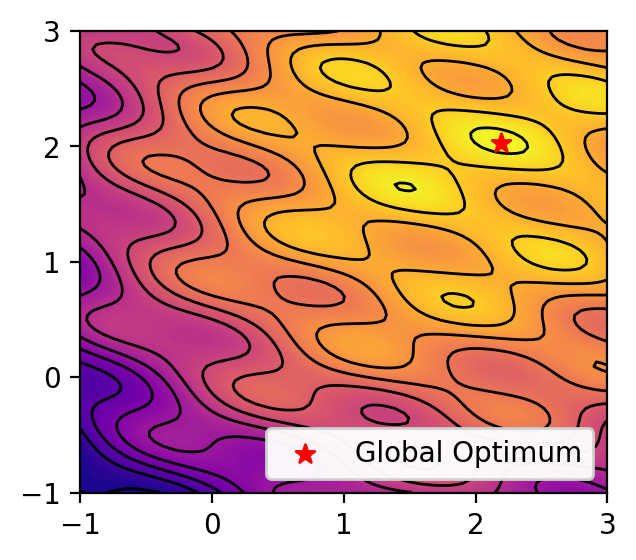

In [1]:
import numpy as np

def f(x, y):
  return np.sin(2.5 * (x - 2 * y)) + np.cos(4.0 * (x + 2 * y)) - ((x - 2.0) ** 2 + (y - 2.0) ** 2)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive, widgets, Layout, interact

# add contour line
plt.rcParams['contour.negative_linestyle'] = 'solid'

class Visualizer:
  def __init__(self, func, x_lim=(-1, 3), y_lim=(-1, 3), res=100, n_contour_lines=15, quantized_values=None):
    xs = np.linspace(*x_lim, res)
    ys = np.linspace(*y_lim, res)
    self.xs, self.ys = np.meshgrid(xs, ys)
    self.zs = func(self.xs, self.ys)

    index = np.argmax(self.zs.reshape(-1))
    self.opt_x, self.opt_y = self.xs.reshape(-1)[index], self.ys.reshape(-1)[index]
    self.x_lim, self.y_lim = x_lim, y_lim

    self.n_contour_lines = n_contour_lines
    self.quantized_values = quantized_values

  def _plot_base_function(self, ax, no_bg=False, alpha=1.0, new_zs=None, new_opt=None):
    if new_zs is not None:
      zs = new_zs
    else:
      zs = self.zs
    if not no_bg:
      ctf = ax.contourf(self.xs, self.ys, zs, 100, cmap='plasma')
    ax.contour(self.xs, self.ys, zs, self.n_contour_lines, linewidths=1, colors="black", alpha=alpha)

    if self.quantized_values is not None:
      assert not no_bg
      patches = []
      for q in self.quantized_values:
        color = ctf.to_rgba(q)
        patches.append(mpatches.Patch(color=color, label=f'$f_q(x, y)={q}$'))
      legend = plt.legend(handles=patches, loc='best', ncol=3, fontsize="small")
      ax.add_artist(legend)
    else:
      if new_opt is None:
        ax.scatter(self.opt_x, self.opt_y, marker="*", s=50, color="red", label="Global Optimum", zorder=4)
      else:
        ax.scatter(self.opt_x, self.opt_y, marker="*", s=50, color="red", label="Global Optimum (Original)", zorder=4, alpha=0.75)
        ax.scatter(*new_opt, marker="*", s=50, color="darkgreen", label="Global Optimum (Smoothed)", zorder=4, alpha=0.75)

  def draw(self, ax, curves=None, no_bg=False, plot_base=True, base_alpha=1.0,
           new_zs=None, new_opt=None, legend=True):
    ax.clear()
    if plot_base:
      self._plot_base_function(ax, no_bg=no_bg, alpha=base_alpha, new_zs=new_zs, new_opt=new_opt)
    if curves is not None:
      for label, curve in curves.items():
        xs = curve["x"]
        ys = curve["y"]

        lines = []
        alphas = np.linspace(0.25, 1., len(xs) - 1)
        for x1, x2, y1, y2 in zip(xs[:-1], xs[1:], ys[:-1], ys[1:]):
            lines.extend([(x1, x2), (y1, y2)])

        ax.plot(*lines, color=curve["color"], linestyle="-", linewidth=2.0, alpha=0.25, zorder=4)
        ax.scatter(xs, ys, marker="o", facecolors='none', edgecolors=curve['color'], s=25, label=label, alpha=0.8, zorder=5)

    ax.set_xticks(np.linspace(-1., 3., 5))
    ax.set_yticks(np.linspace(-1., 3., 5))
    ax.set_xlim(*self.x_lim)
    ax.set_ylim(*self.y_lim)
    if legend:
      handles, labels = ax.get_legend_handles_labels()
      legend = plt.legend(handles=handles, labels=labels, loc='lower right')
      ax.add_artist(legend)


visualizer = Visualizer(f)

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.0), dpi=200)
visualizer.draw(ax)

As you may have already noticed, there are a lot of local optima in this function. Would this be an issue for gradient descent method? Let's take a look!


## Part 1. Gradient Ascent

In this part, we are going to implement gradient ascent and see how it does on this objective function. Your task is to fill in the `gd_step` function below. The function takes in the parameters $x_t$, $y_t$, and the learning rate $\eta$ and outputs a tuple $(x_{t+1}, y_{t+1})$ after one gradient step:

$$x_{t+1} \leftarrow x_t + \eta \frac{\partial f}{\partial x}(x_t, y_t),$$
$$y_{t+1} \leftarrow y_t + \eta \frac{\partial f}{\partial x}(x_t, y_t).$$

Your code should be able to take either scalar $x$ and $y$ or numpy arrays of $x$ and $y$ as input (in that case your output would be a tuple of array rather than a tuple of scalars).

Once you are done impelementing the function, run the cell below and see how gradient ascent optimizes this objective function (you will see the trajectory of $\{(x_1, y_1), \cdots, (x_T, y_T)\}$). You should feel free to change the initialization of $x, y$ parameters and see how different initializations change the optimization trajectory (the line where it says `CHANGE ME!` below).

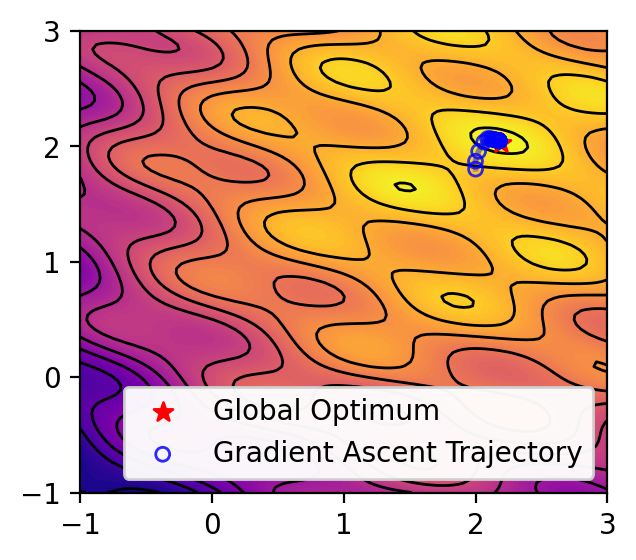

In [6]:
def grad_f(x, y):
  dx = 2.5 * np.cos(2.5 * (x - 2 * y)) - 4.0 * np.sin(4.0 * (x + 2 * y)) - 2.0 * (x - 2.0)
  dy = -5.0 * np.cos(2.5 * (x - 2 * y)) - 8.0 * np.sin(4.0 * (x + 2 * y)) - 2.0 * (y - 2.0)
  return dx, dy

num_its = 100

def gd_step(x, y, eta):
  dx, dy = grad_f(x, y)
  new_x = x + eta * dx
  new_y = y + eta * dy

  return new_x, new_y

num_its = 30      # number of gradient steps
eta = 0.01        # learning rate
# x, y = -0.3, 0.5  # initial parameter values (CHANGE ME!)
x, y = 2.0, 1.8

# history of parameter values
xs = [x]
ys = [y]

for i in range(num_its):
    x, y = gd_step(x, y, eta)
    xs.append(x)
    ys.append(y)

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.0), dpi=200)
visualizer.draw(ax, {f"Gradient Ascent Trajectory": {"color": "blue", "x": xs, "y": ys}})

--------------
**(a). What do you observe from the optimization trajectory of your $(x, y)$ parameters? Where do your parameters converge to? Try a few different initialization values and see how the convergence changes.**

The optimization trajectory of normal Gradient Ascend moves a little in the whole plane and converges to a local maximum value, which is actually far
away from the global maximum.

If we try different initializaions, the convergence will vary according to the maximum value in its neighborhood, but still can't
reach the global maximunm eveytime.

--------------

In the next part, we are going to cluster these initialization locations by their values at the end of their optimization trajectories.

In [7]:
# we put all points that are less than eps apart (Euclidean distance) together.
def manual_clustering(t_xs, t_ys, max_num_clusters=23, eps=1e-2):
  labels = np.zeros_like(t_xs, dtype=int)

  codebook = []
  while True:
    unlabeled_indx, unlabeled_indy = np.nonzero(labels == 0)
    if len(unlabeled_indx) == 0 or len(codebook) > max_num_clusters: break

    first = (unlabeled_indx[0], unlabeled_indy[0])
    codebook.append(np.array([t_xs[first], t_ys[first]]))

    matched = (t_xs[first] - t_xs) ** 2 + (t_ys[first] - t_ys) ** 2 <= eps * eps
    labels[matched] = len(codebook)

  # codebook stores an array of representative point in the cluster
  # labels stores an array of index that represents which cluster each example belongs to
  return np.stack(codebook), labels

# generate a grid of initialization points
t_xs, t_ys = np.linspace(-1, 3, 100), np.linspace(-1, 3, 100)
t_xs, t_ys = np.meshgrid(t_xs, t_ys)
num_its = 1000

# run gradient ascent
t_xs_history, t_ys_history = [t_xs], [t_ys]
for i in range(num_its):
    t_xs, t_ys = gd_step(t_xs, t_ys, 0.01)
    t_xs_history.append(t_xs)
    t_ys_history.append(t_ys)

# cluster them based on the final parameter values
codebook, labels = manual_clustering(t_xs, t_ys)

Let's take a look at all the local maxima (the "x" symbols) that we obtained from clustering.

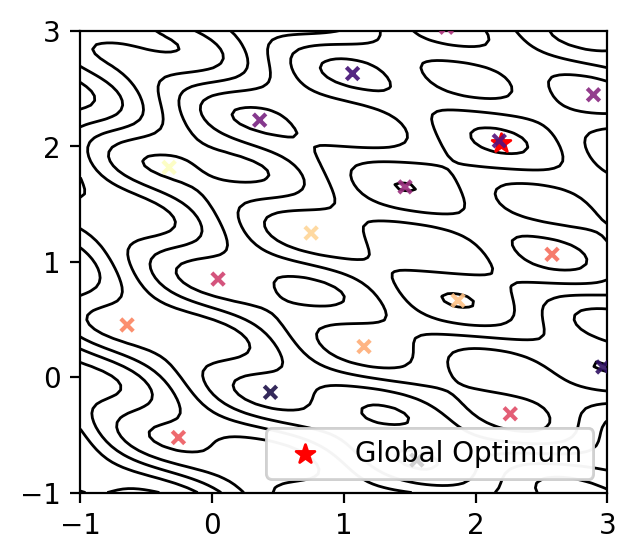

In [8]:
import random
cmap = matplotlib.colormaps['magma']
colors = [cmap(x) for x in np.linspace(0, 1.0, len(codebook) + 1)]
random.seed(2)
random.shuffle(colors)
colors = np.array(colors)

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3), dpi=200)
visualizer.draw(ax, no_bg=True)
ax.scatter(codebook[:, 0], codebook[:, 1], color=colors[:-1], alpha=0.9, s=20, marker="x", zorder=5)

Now, we can visualize the trajectories of these clustered initialization points colored with their corresponding clustering labels via the following interaction widget. The slider corresponds to the gradient step. At step 0, we can see the [basins of attraction](https://en.wikipedia.org/wiki/Attractor) towards these local optima. Try to drag the slider yourself to see how each initialization moves throughout the optimization process!

In [9]:
def update_images(i):
  fig, ax = plt.subplots(1, 1, figsize=(3.4, 3), dpi=200)
  ax.set_facecolor('lightgray')
  visualizer.draw(ax, no_bg=True)
  ax.scatter(t_xs_history[i].reshape(-1), t_ys_history[i].reshape(-1), facecolors='none', edgecolors=colors[labels.reshape(-1)], alpha=0.3, s=20, marker="o", zorder=5)
  plt.show()

slider = widgets.IntSlider(
    value=0,
    min=0,
    max=100,
    description="# of gd steps"
)
interact(update_images, i=slider)

interactive(children=(IntSlider(value=0, description='# of gd steps'), Output()), _dom_classes=('widget-intera…

<function __main__.update_images(i)>

--------------
**(b) What patterns do you observe from the basins of attraction visualization? How do they relate to the sine and cosine in our objective function?**

The basins of attraction took almost the same size of their neighbors, and change in a steady frequency, which may relate to the sine and cosine functions' cycle.

--------------

Next, we study how the optimization trajectory changes as the learning rate changes. Try to drag the slider to change the learning rate below and see how the trajectories from different initialization points change!

In [10]:
import matplotlib
from functools import partial

cmap = matplotlib.colormaps['ocean']
seed = 1437

rng = np.random.default_rng(seed=seed)
num_its = 15
num_inits = 3
init_xs, init_ys = rng.random(num_inits) * 0.9, rng.random(num_inits) * 1.2
colors = [cmap(x) for x in np.linspace(0, 0.6, num_inits)]

def generate_curves(eta, optimizer, num_its, num_inits):
  xs, ys = np.empty((num_its + 1, num_inits)), np.empty((num_its + 1, num_inits))
  xs[0], ys[0] = init_xs, init_ys
  for i in range(1, num_its + 1):
    xs[i], ys[i] = optimizer(xs[i-1], ys[i-1], eta)

  curves = {}
  for i in range(num_inits):
    curves[f"Trajectory (Init #{i+1})"] = {"color": colors[i], "x": xs[:, i], "y": ys[:, i]}
  return curves


def get_interactive(visualizer, ax, gen_fn):

  def update_images(eta):
    fig, ax = plt.subplots(1, 1, figsize=(4.0, 4.0), dpi=200)
    curves = gen_fn(eta)
    visualizer.draw(ax, curves)

  slider = widgets.FloatLogSlider(
      value=0.001,
      base=10,
      min=-3, # min exponent of base
      max=-1, # max exponent of base
      step=0.2, # exponent step
      description='eta'
  )
  return interactive(update_images, eta=slider)

ip = get_interactive(visualizer, ax, partial(generate_curves, optimizer=gd_step, num_its=num_its, num_inits=num_inits))
ip

interactive(children=(FloatLogSlider(value=0.001, description='eta', max=-1.0, min=-3.0, step=0.2), Output()),…

--------------
**(c) What do you notice when the learning rate $\eta$ changes? Is there a good learning rate that makes it more likely to find the global optimum?**

When the learning rates are rather small, the learning process remains the same
as above, and converge to the local maximum in their neightborhood. But as the learning rates increase, the step sizes become larger and the Gradient Ascend model is able to "jump out of" the local maximum and achieve to the global maximum following the overall trend. A learning rate of 0.0631 is more likely to makes it find the global optimum.

--------------

## Part 2: Smoothing the optimzation problem

We have seen that it is very difficult for gradient ascent to find the global optimum relibly unless the initialization is close to the global optimum. This is due to all the small "hills" and "puddles" that trap the optimization trajectories. Can we optimize a different problem that has a similar global optimum but a much nicer objective landscape?

In this part, we explore a smoothing technique that converts the original objective function into a more smoothed one. In particular, we convolve a 2-D Gaussian kernel over the function ([convolution](https://en.wikipedia.org/wiki/Convolution), [Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)):

$$f_{\sigma}(x, y) = \mathbb{E}_{\tilde{x} \sim \mathcal{N}(x, \sigma^2), \tilde{y} \sim \mathcal{N}(y, \sigma^2)}\left[f(\tilde{x}, \tilde{y})\right]$$

We can view this convolution operation as a continous interpretation of the convolution layer (e.g., as the image approaches inifinite resolution).

Let's first try to visualize the smoothed objective. Since we can't exactly compute the expectation, we are going to approximate it with a Monte-Carlo estimate:
$$\hat{f}_\sigma(x, y) = \frac{1}{N} \sum_{i} \left[f(\tilde{x}_i, \tilde{y}_i)\right]$$
with $\tilde{x}_1, \tilde{x}_2, \cdots, \tilde{x}_N$ being independent samples from $\mathcal{N}(x, \sigma^2)$ and $\tilde{y}_1, \tilde{y}_2, \cdots, \tilde{y}_N$ being independent samples from $\mathcal{N}(y, \sigma^2)$.

Your task is to implement the `smoothed_f` function below that returns a Monte-Carlo estimate of $f_\sigma$ using parameters $\sigma$ and $N$. The function should return a float scalar.

In [12]:
def smoothed_f(x, y, sigma, N):
  x_hat = np.random.randn(N)*sigma + x
  y_hat = np.random.randn(N)*sigma + y
  return np.mean(f(x_hat, y_hat))

In [13]:
zs_dict = {}
opt_dict = {}
for sigma in [0.01, 0.1, 0.2, 0.3, 0.5]:
  zs = []
  xs, ys = visualizer.xs, visualizer.ys
  for x, y in zip(xs.reshape(-1), ys.reshape(-1)):
    zs.append(smoothed_f(x, y, sigma, N=10000))
  zs_dict[sigma] = np.array(zs).reshape(xs.shape)
  index = np.argmax(zs_dict[sigma].reshape(-1))
  opt_dict[sigma] = (xs.reshape(-1)[index], ys.reshape(-1)[index])

In [14]:
def update_images(sigma):
  fig, ax = plt.subplots(1, 1, figsize=(4.0, 4.0), dpi=200)
  xs, ys = visualizer.xs, visualizer.ys
  zs = zs_dict[sigma]
  ax.contourf(xs, ys, zs, 50, cmap='plasma')
  ax.contour(xs, ys, zs, 15, linewidths=1, colors="black")

  ax.scatter(visualizer.opt_x, visualizer.opt_y, marker="*", s=50, color="red", label="Global Optimum (Original)", alpha=0.5, zorder=4)
  ax.scatter(*opt_dict[sigma], marker="*", s=50, color="darkgreen", label="Global Optimum (Smoothed)", alpha=0.5, zorder=4)
  ax.legend()

slider = widgets.SelectionSlider(
    options=[0.01, 0.1, 0.2, 0.3, 0.5],
    value=0.01,
    description='sigma',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
interactive(update_images, sigma=slider)

interactive(children=(SelectionSlider(continuous_update=False, description='sigma', options=(0.01, 0.1, 0.2, 0…

--------------

**(d) Take a close look at the global optimum for the original function (red star) and the global optimum for the smoothed function (blue star). What do you observe as $\sigma$ increases? Why? Can you give an example where the global optimum of the smoothed function is very far from the global optimum of the original function?**

As $\sigma$ increases, the two optimum seperate from each other. Yes, consider
a very large $\sigma$, which corresponds to a large Gaussian kernel, and will reault in a large "plane" of maximum. In this case, the "smooth" optimum is likely to be far from the original one, but they both lie on the "plane".

--------------

Our smoothed function successfully removes all the local optimum except the global optimum. However, we don't know how to optimize this smoothed function efficiently yet. The key challenge here is that we actually don't have a good idea on how to differentiate through $f_\sigma$ or approximate $\nabla f_\sigma$.

In the following part, we will be exploring three different optimization techniques to address this issue. We are going to use $\sigma=0.3$

## Part 3a: Finite-difference method

The first method that we are going to explore is the finite-difference method where we are going to approximate the gradient by trying to step in each dimension of $\theta$ and evaluate the difference in the objective function:

$$ \frac{\partial f_{\sigma}(x, y)}{\partial x} \approx \frac{\hat{f}_{\sigma}(x + \delta, y) - \hat{f}_{\sigma}(x, y)}{\delta}$$
$$ \frac{\partial f_{\sigma}(x, y)}{\partial y} \approx \frac{\hat{f}_{\sigma}(x, y + \delta) - \hat{f}_{\sigma}(x, y)}{\delta}$$

where $\hat{f}(x, y)$ is the Monte-Carlo estimate of $f(x, y)$ using random samples of $x$ and $y$ from the Gaussian distribution (same as the $\hat{f}$ in the previous part).

Your task is to implement the `finite_diff_grad_step` function below. In the function, you should first estimate the gradient of the smoothed function $f_\sigma$ using the finite-difference method using $\delta$, $\sigma$, and $N$. Then, you should use the gradient estimate to take a step with a step size of $\eta$ and return the new parameter values.

In [ ]:
def finite_diff_grad_step(x, y, delta, N, eta, sigma):
  tx = np.random.normal(x, sigma, size=(N,)) # tilde x samples
  ty = np.random.normal(y, sigma, size=(N,)) # tilde y samples
  #############################################################################
  # TODO: Implement the finite-difference gradient estimator of the smoothed  #
  #   function f.                                                             #
  #############################################################################
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  return new_x, new_y

num_its = 30      # number of gradient steps
eta = 0.1         # learning rate
delta = 0.25      # finite difference magnitude
N = 20            # number of samples for MC estimation
sigma = 0.3       # the magnitude of the Gaussian noise.
x, y = -0.3, 0.5  # initial parameter values

# history of parameter values
xs = [x]
ys = [y]

for i in range(num_its):
    x, y = finite_diff_grad_step(x, y, delta, N, eta, sigma)
    xs.append(x)
    ys.append(y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.2, 3.2), dpi=200)
visualizer.draw(ax1, {f"FD Trajectory": {"color": "blue", "x": xs, "y": ys}}, new_opt=opt_dict[sigma], legend=False)
visualizer.draw(ax2, {f"FD Trajectory": {"color": "blue", "x": xs, "y": ys}}, new_zs=zs_dict[sigma], new_opt=opt_dict[sigma], legend=False)

ax1.set_title("Original ($f$)")
ax2.set_title("Smoothed ($f_\sigma$)")
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.08))

Now, we are going to look at how changing $\eta$, $\delta$ and $N$ influences the learning trajectory. Run the following cell and drag the sliders to try it out yourself!

In [ ]:
def get_interactive(grad_step_fn, label_name, init_x=-0.3, init_y=0.5, num_its=30, has_delta=False):

  def generate_curves(*args, **kwargs):
    x, y = init_x, init_y
    xs, ys = [init_x], [init_y]
    for i in range(1, num_its + 1):
      x, y = grad_step_fn(x, y, *args, **kwargs)
      xs.append(x)
      ys.append(y)

    return {label_name: {"color": "blue", "x": xs, "y": ys}}

  def update_images(*args, **kwargs):
    sigma=0.3
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.2, 3.2), dpi=200)
    curves = generate_curves(*args, **kwargs, sigma=sigma)

    visualizer.draw(ax1, curves, new_opt=opt_dict[sigma], legend=False)
    visualizer.draw(ax2, curves, new_zs=zs_dict[sigma], new_opt=opt_dict[sigma], legend=False)

    ax1.set_title("Original ($f$)")
    ax2.set_title("Smoothed ($f_\sigma$)")
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.08))
    plt.show()

  eta_slider = widgets.FloatLogSlider(
      value=0.1,
      base=10,
      min=-3, # min exponent of base
      max=0, # max exponent of base
      step=0.2, # exponent step
      description='eta'
  )

  N_slider = widgets.SelectionSlider(
      options=[1, 2, 5, 10, 20, 50, 100],
      value=20,
      description='N',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True
  )
  if has_delta:
    delta_slider = widgets.FloatLogSlider(
        value=0.3,
        base=10,
        min=-3, # min exponent of base
        max=0, # max exponent of base
        step=0.2, # exponent step
        description='delta'
    )
    return interactive(update_images, N=N_slider, eta=eta_slider, delta=delta_slider)
  return interactive(update_images, N=N_slider, eta=eta_slider)

get_interactive(finite_diff_grad_step, "FD Trajectory", has_delta=True)

--------------
**(e) What do you observe when you change $\delta$, $\eta$ (learning rate) and $N$ (the sample size for Monte-Carlo estimate)?**

*(your answer)*

--------------

## Part 3b: Policy Gradient

Finite-difference method uses zero gradient information about the objective function. Can we come up with a technique that uses more information about our smoothed function?

In this part, you will learn about a technique that leverages the gradient information of the probability density function of the Gaussian kernel to better estimate the gradient of the smoothed function.

To start with, let's first write out the smoothed function in the integral form:

$$f_{\sigma}(x, y) = \mathbb{E}_{\tilde{x}, \tilde{y} \sim \mathcal{N}([x, y]^\top, \sigma^2I)}\left[f(\tilde{x}, \tilde{y})\right] = \int_{\tilde x}\int_{\tilde y} p(\tilde{x}, \tilde{y} | x, y) f(\tilde{x}, \tilde{y}) d\tilde xd\tilde y$$
where $p(\tilde{x}, \tilde{y} | x, y) = \frac{1}{2\pi\sigma} \exp\left(-\frac{(\tilde{x} - x)^2 + (\tilde{y} - y)^2}{2\sigma^2}\right)$.

Now, we can take the derivative with respect to $x$:
$$\frac{\partial f_\sigma(x, y)}{\partial x} = \int\int \frac{\partial p(\tilde{x}, \tilde{y} | x, y)}{\partial x} f(\tilde{x}, \tilde{y}) d\tilde xd\tilde y = \int\int \frac{1}{2\pi\sigma} \exp\left(-\frac{(\tilde{x} - x)^2 + (\tilde{y} - y)^2}{2\sigma^2}\right) \left[(\tilde x - x)/\sigma^2\right] f(\tilde{x}, \tilde{y}) d\tilde xd\tilde y$$

While it is nice that we can represent it in the integral form, we don't know how to tractably compute it. So how should we proceed from here?

You might have already observed that there is a term in the operand of the integral that is same as $p(\tilde x, \tilde y | x, y)$. This means that we can actually put the result back to the expectation form!
$$\frac{\partial f_\sigma(x, y)}{\partial x} = \int \int p(\tilde{x}, \tilde{y} | x, y) (x - \tilde x) f(\tilde x, \tilde y)/\sigma^2 d\tilde x d\tilde y = \mathbb{E}\left[(\tilde x - x) f(\tilde x, \tilde y)/\sigma^2\right]$$

By symmetry, we also have
$$\frac{\partial f_\sigma(x, y)}{\partial y} = \mathbb{E}\left[(\tilde y - y) f(\tilde x, \tilde y)/\sigma^2\right]$$

With the gradient of the smoothed function in the expectation form, we can use it to approximate the gradient using Monte-Carlo estimation:
$$\frac{\partial f_\sigma(x, y)}{\partial x} \approx \frac{1}{N}\sum_{i}\left[(\tilde x_i - x) f(\tilde x_i, \tilde y_i)/\sigma^2\right]$$
$$\frac{\partial f_\sigma(x, y)}{\partial y} \approx \frac{1}{N}\sum_{i}\left[(\tilde y_i - y) f(\tilde x_i, \tilde y_i)/\sigma^2\right]$$
where again $\{\tilde x_i\}_{i=1}^{N}$, $\{\tilde y_i\}_{i=1}^{N}$ are independent samples of $\mathcal{N}(x, \sigma^2)$ and $\mathcal{N}(y, \sigma^2)$ respectively. The gradient estimator of such form is called the *policy gradient estimator* or *score function gradient estimator*.

--------------

**(f) Can you provide an intuitive explanation of why the gradient estimator works? (Hint: which direction is the gradient estimator trying to push $(x, y)$ into? By what magnitude?)**

*(your answer)*

--------------

Now comes the question -- What if $p(\tilde x, \tilde y | x, y)$ is not Gaussian? Is there still a nice way to rewrite the gradient of the smoothed function as an expectation of something? You will explore this more in the written part of your homework!

For now, your task is to implement the `pg_grad_step` function below. In the function, you should first estimate the gradient of the smoothed function $f_\sigma$ using the policy gradient method using $\sigma$, and $N$. Then, you should use the gradient estimate to take a step with a step size of $\eta$ and return the new parameter values.

In [ ]:
def pg_grad_step(x, y, N, eta, sigma):
  tx = np.random.normal(x, sigma, size=(N,)) # tilde x samples
  ty = np.random.normal(y, sigma, size=(N,)) # tilde y samples
  #############################################################################
  # TODO: Implement the policy gradient estimator for the smoothed function f #
  #############################################################################
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  return new_x, new_y

num_its = 30      # number of gradient steps
eta = 0.1         # learning rate
N = 20            # number of samples for MC estimation
sigma = 0.3       # the magnitude of the Gaussian noise
x, y = -0.3, 0.5  # initial parameter values

# history of parameter values
xs = [x]
ys = [y]

for i in range(num_its):
    x, y = pg_grad_step(x, y, N, eta, sigma)
    xs.append(x)
    ys.append(y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.2, 3.2), dpi=200)
visualizer.draw(ax1, {f"PG Trajectory": {"color": "blue", "x": xs, "y": ys}}, legend=False)
visualizer.draw(ax2, {f"PG Trajectory": {"color": "blue", "x": xs, "y": ys}}, new_zs=zs_dict[sigma], legend=False)

ax1.set_title("Original ($f$)")
ax2.set_title("Smoothed ($f_\sigma$)")
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.08))
pass

Now, we are going to look at how changing $\eta$ and $N$ influences the learning trajectory. Run the following cell and drag the sliders to try it out yourself!

In [ ]:
get_interactive(pg_grad_step, "PG Trajectory", has_delta=False)

--------------
**(g) What do you observe when you change $\eta$ (learning rate) and $N$ (the sample size for Monte-Carlo estimate)?**

*(your answer)*

--------------

## Part 3c: Reparameterization Gradient

Policy gradient uses the information about the smoothing kernel to provide a better gradient estimation. Can we use any gradient information about $f(x)$? This might seem a bit unintuitive, as the function that has lots of local optima probably have poor gradient information locally. As we will show in this part, we can actually harness the poor gradient information to provide better gradient estimation of the smoothed function.

Let's go back to the definition of the smoothed function again (and take the gradient operator with respect to $[x, y]$):
$$\nabla f_\sigma(x, y) = \nabla \mathbb{E}_{\tilde x, \tilde y \sim \mathcal{N}([x, y], \sigma^2 I)}\left[f(\tilde x, \tilde y)\right]$$

It would be so nice if we could move the gradient inside the expectation, but that is not possible immediately because the expectation distribution depends on $x$ and $y$ and the term inside the expectation does not directly depend on $x$ and $y$. Can we somehow rewrite the expectation such that the distribution does not depend on $x$ and $y$? Or in another word, can we separate out the noise in $\tilde x$ and $\tilde y$ such that they can be rewritten as a deterministic function of $x, y$ and some noise that is independent of $x$ and $y$?

Yes! Let $z_x, z_y$ be independent samples from the Gaussian $\mathcal{N}(0, \sigma^2)$. We can simply rewrite $\tilde x$ and $\tilde y$ as follows:
$$\tilde x = z_x + x,$$
$$\tilde y = z_y + y.$$

With such a reparameterization, we can now express the smoothed function using an expectation where its distribution is independent of $x$ and $y$! This would allow us to move the gradient operator inside:
$$\nabla f_\sigma(x, y) = \nabla \mathbb{E}_{z_x, z_y \sim \mathcal{N}(0, \sigma^2)}\left[f(x + z_x, y + z_y)\right] = \mathbb{E}_{z_x, z_y \sim \mathcal{N}(0, \sigma^2)} \left[\nabla f(x + z_x, y + z_y)\right]$$

Writing out the derivative for $x$ and $y$ separately:
$$\frac{\partial f_\sigma(x, y)}{\partial x} = \mathbb{E}_{z_x, z_y \sim \mathcal{N}(0, \sigma^2)}\left[f_x(x + z_x, y + z_y)\right]$$
$$\frac{\partial f_\sigma(x, y)}{\partial y} = \mathbb{E}_{z_x, z_y \sim \mathcal{N}(0, \sigma^2)}\left[f_y(x + z_x, y + z_y)\right]$$
where $f_x$ is the partial derivative of $f$ with respect to the first input ($x$) and $f_y$ is the partial derivative of $f$ with respect to the second input ($y$).

As you might have already guessed it, we can perform Monte-Carlo estimate of each of the derivative by drawing $z_x$ and $z_y$ samples. The gradient estimator of such form is called the *reparameterization gradient estimator*.

Your task is to implement the `reparam_grad_step` function below. In the function, you should first estimate the gradient of the smoothed function $f_\sigma$ using the reparameterization gradient method using $\sigma$, and $N$. Then, you should use the gradient estimate to take a step with a step size of $\eta$ and return the new parameter values.

In [ ]:
def reparam_grad_step(x, y, N, eta, sigma):
  tx = np.random.normal(x, sigma, size=(N,)) # tilde x samples
  ty = np.random.normal(y, sigma, size=(N,)) # tilde y samples
  #############################################################################
  # TODO: Implement the reparameterization gradient estimator of the smoothed #
  #   function f.                                                             #
  #############################################################################
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  return new_x, new_y


num_its = 30      # number of gradient steps
eta = 0.1         # learning rate
N = 20            # number of samples for MC estimation
sigma = 0.3       # the magnitude of the Gaussian noise
x, y = -0.3, 0.5  # initial parameter values

# history of parameter values
xs = [x]
ys = [y]

for i in range(num_its):
    x, y = pg_grad_step(x, y, N, eta, sigma)
    xs.append(x)
    ys.append(y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.2, 3.2), dpi=200)
visualizer.draw(ax1, {f"Reparam Trajectory": {"color": "blue", "x": xs, "y": ys}}, legend=False)
visualizer.draw(ax2, {f"Reparam Trajectory": {"color": "blue", "x": xs, "y": ys}}, new_zs=zs_dict[sigma], legend=False)

ax1.set_title("Original ($f$)")
ax2.set_title("Smoothed ($f_\sigma$)")
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.08))
pass

In [ ]:
get_interactive(reparam_grad_step, "Reparam Trajectory", has_delta=False)

--------------
**(h) Compare the trajectory of reparam gradient vs. policy gradient. What do you observe? Is one more straight than the other one? Why do you think that is the case?**

*(your answer)*

--------------

## Part 4: Objective functions with discontinuities

In the previous part, we introduced three optimization techniques to find the global optimum of a smoothed function. In this part, we are going to explore a more extreme objective function that contains discontinuities, $f_q(x, y)$. $f_q$ is obtained by quantizing the objective function that we were using in the previous parts. Can we use what we have learned so far to optimize this objective function?

Let's first visualize what the function looks like!

In [ ]:
def quantize(s):
  return np.floor(s / 4.5 + 0.64)

def qf(x, y):
  return quantize(np.sin(2.5 * (x - 2 * y)) + np.cos(4.0 * (x + 2 * y)) - ((x - 2.0) ** 2 + (y - 2.0) ** 2))

q_visualizer = Visualizer(qf, n_contour_lines=5, quantized_values=[-4, -3, -2, -1, 0, 1])

fig, ax = plt.subplots(1, 1, figsize=(4.70, 4.70), dpi=200)
q_visualizer.draw(ax, legend=False)

From the visualization, the function only outputs values from $\{-4, -3, -2, -1, 0, 1\}$ with $f_q(x, y) = 1$ being the maximum value (located top right, yellow region).

--------------
**(i) How well do you expect naive gradient descent algorithm to perform on this quantized objective function? Explain Why.**

*(your answer)*

**(j) Can you use reparameterization gradient for this function? Explain why. What about finite-difference?**

*(your answer)*

--------------

Your task below is to write code to use a suitable technique that you learned above to reach the maximum region of this quantized function. We provide some helper code below to get you started. Depending on the technique you use, you may or may not need $\delta$ in the function input. You should be able to reach the maximum region under 30 gradient steps and $N\leq 50$ with high probability (>85%).

In [ ]:
def q_grad_step(x, y, N, eta, sigma, delta):
  tx = np.random.normal(x, sigma, size=(N,)) # tilde x samples
  ty = np.random.normal(y, sigma, size=(N,)) # tilde y samples
  #############################################################################
  # TODO: Implement the policy gradient  estimate of the gradient of the      #
  # smoothed function f. (Hint: make sure to use qf instead of f as used      #
  # previously                                                                #
  #############################################################################
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  return new_x, new_y

num_its = 30      # number of gradient steps
eta = 0.5         # learning rate
N = 50            # number of samples for MC estimation
sigma = 0.3       # the magnitude of the Gaussian noise
delta = 0.25      # finite difference magnitude
x, y = -0.3, 0.5  # initial parameter values

# history of parameter values
xs = [x]
ys = [y]

#############################################################################
# TODO: Implement the for loop that takes policy gradient steps. Make sure  #
# to append your intermediate x and y values into the list xs and ys so that#
# the training trajectory can be visualized later (hint: you might find the #
# code you have seen in the previous part helpful)                          #
#############################################################################
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

fig, ax = plt.subplots(1, 1, figsize=(4.70, 4.70), dpi=200)
q_visualizer.draw(ax, {f"PG Trajectory": {"color": "blue", "x": xs, "y": ys}})